## 本次作業主題，做回歸分析 (使用線性回歸模型)
#### **問題** : 新竹地區2020年10~12月之空氣品質資料，進行時間序列分析&迴歸預測pm2.5值
- 資料來源 :  https://airtw.epa.gov.tw/CHT/Query/His_Data.aspx  
- 一般測站資料註記說明： 
  1. **#** 表示儀器檢核為無效值
  2. **\*** 表示程式檢核為無效值
  3. **x** 表示人工檢核為無效值
  4. **A** 係指因儀器疑似故障警報所產生的無效值
  5. **空白** 表示缺值
- 流程 :
    1. 閱覽資料 : 整理表格，處理讀檔問題(utf-8)編碼，(可能在不同界面上讀檔會有問題，colab無法順利執行，在jupyter lab 可以成功)
    2. 處理上述符號型資料 : 因為是時間序列資料，利用前後小時的資料補齊缺失值，若前一小時也是缺失值，則在往前找非缺失值的數值取平均(需要非常小心，要先把表格重新排序表示) 
    3. 整理資料架構 : 因為是要利用前6小時該第17種欄位屬性去預測第18種資料**PM2.5**，
       故需要先調整資料架構
    4. 放入模型 : LinearRegression 訓練線性回歸模型
    5. 預測結果 : 計算 MAE(mean absolute error)

#### Note: 新竹_2020.csv資料可能遇到讀取問題，如遇到問題可以由下列步驟解決
1. .csv --> .txt
2. 開啟.txt左上檔案另存為
3. 顯則所有檔案，最下方欄位改成 UTF-8 相關編碼(eg. 具有BOM UTF-8)
4. 使用 `pandas` 的 `read_csv` 即可正常讀取

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
FIGURE_ROOT = 'figure'
FILENAME = '新竹_2020.csv'

df = pd.read_csv(FILENAME)  # encoding = "gb18030")
df.drop(0,inplace=True)     # remove the first row
display(df.head(5))

,測站,日期,測項,00,01,02,03,04,05,06,...,14,15,16,17,18,19,20,21,22,23
1,新竹,2020/01/01 00:00:00,AMB_TEMP,15.2,15.2,15.3,15.3,15.3,15.4,15.5,...,18.1,18.2,17.9,17.3,16.7,16.4,16.2,16.1,16,15.8
2,新竹,2020/01/01 00:00:00,CH4,1.74,1.74,1.77,1.78,1.77,1.77,1.77,...,1.78,1.78,1.77,1.8,1.81,1.82,1.85,1.83,1.92,1.94
3,新竹,2020/01/01 00:00:00,CO,0.28,0.25,0.24,0.22,0.2,0.19,0.2,...,0.28,0.29,0.28,0.34,0.39,0.41,0.46,0.49,0.58,0.52
4,新竹,2020/01/01 00:00:00,NMHC,0.06,0.07,0.05,0.05,0.05,0.05,0.07,...,0.09,0.09,0.07,0.08,0.12,0.12,0.16,0.14,0.17,0.2
5,新竹,2020/01/01 00:00:00,NO,0.3,0.6,0.6,0.6,0.3,0.3,0.5,...,1.6,1.6,1.2,0.7,0.9,1.1,1.1,1.7,1.8,1.4


In [3]:
profile = ProfileReport(df, title='PM2.5_In_Hsinchu', explorative=True)
profile.to_file('PM2p5_In_Hsinchu.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 281.69it/s]


- 去除欄位值空格
    - 欄位空隔值 
    - `測項`也具空隔值

In [4]:
Renew_columns = [columns.strip() for columns in df.columns]
Renew_columns_map = dict(zip(df.columns, Renew_columns))
df.rename(columns=Renew_columns_map, inplace=True)

display(df.columns)
display(df['測項'].apply(lambda x:x.strip()).unique(), len(df['測項'].unique()))

Index(['測站', '日期', '測項', '00', '01', '02', '03', '04', '05', '06', '07', '08',
       '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '22', '23'],
      dtype='object')

array(['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10',
       'PM2.5', 'RAINFALL', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC',
       'WIND_SPEED', 'WS_HR'], dtype=object)

18

## 1. 取出需要的資料

 ### a. 取出 10, 11, 12 月資料

In [5]:
def get_spec_month_index(months):
    return lambda x:True if x.split('/')[1] in months else False

month_Index = df['日期'].apply(get_spec_month_index(months=['10', '11', '12']))
data = df[month_Index].iloc[:,3:].copy()


data.head(3)

# months = ['10', '11']
# train_Index = df['日期'].apply(get_spec_month_index(months=['10', '11']))
# train_df = df[train_Index].copy()

# test_Index = df['日期'].apply(get_spec_month_index(months=['12']))
# test_df = df[test_Index].copy()

,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
4933,23.7,23.8,23.8,23.9,23.9,23.8,24.1,24.7,26,27.2,...,29.9,29.6,28.7,27.5,26.4,25.7,25.5,25.3,24.9,24.5
4934,1.97,1.95,1.96,1.96,1.95,1.96,1.97,1.97,1.96,1.98,...,1.97,1.98,1.97,2,2.03,2.04,2.05,2.02,2.1,2.14
4935,0.23,0.22,0.21,0.2,0.2,0.22,0.24,0.29,0.27,0.33,...,0.29,0.3,0.33,0.38,0.46,0.5,0.45,0.39,0.46,0.45


In [6]:
df[month_Index]

,測站,日期,測項,00,01,02,03,04,05,06,...,14,15,16,17,18,19,20,21,22,23
4933,新竹,2020/10/01 00:00:00,AMB_TEMP,23.7,23.8,23.8,23.9,23.9,23.8,24.1,...,29.9,29.6,28.7,27.5,26.4,25.7,25.5,25.3,24.9,24.5
4934,新竹,2020/10/01 00:00:00,CH4,1.97,1.95,1.96,1.96,1.95,1.96,1.97,...,1.97,1.98,1.97,2,2.03,2.04,2.05,2.02,2.1,2.14
4935,新竹,2020/10/01 00:00:00,CO,0.23,0.22,0.21,0.2,0.2,0.22,0.24,...,0.29,0.3,0.33,0.38,0.46,0.5,0.45,0.39,0.46,0.45
4936,新竹,2020/10/01 00:00:00,NMHC,0.06,0.05,0.03,0.03,0.03,0.04,0.04,...,0.06,0.07,0.09,0.11,0.13,0.15,0.1,0.07,0.12,0.18
4937,新竹,2020/10/01 00:00:00,NO,1.2,0.7,0.5,0.7,0.5,0.3,0.7,...,1.3,1,0.9,0.8,0.5,0.9,0.9,0.3,0.7,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6584,新竹,2020/12/31 00:00:00,THC,2.01,2.02,2,2,1.99,2,1.98,...,2.03,2.07,2.07,2.1,2.1,2.07,2.07,2.05,2.04,2.07
6585,新竹,2020/12/31 00:00:00,WD_HR,54,55,54,53,58,52,52,...,54,50,52,45,47,42,42,47,45,44
6586,新竹,2020/12/31 00:00:00,WIND_DIREC,53,52,57,58,49,54,36,...,48,43,44,33,50,40,46,46,51,38
6587,新竹,2020/12/31 00:00:00,WIND_SPEED,4.7,4.6,4.7,4.9,4.1,5.3,5.5,...,4.5,4.4,4.2,3.8,3.7,4.7,4.5,4.4,3.9,3.9


In [7]:
data

,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
4933,23.7,23.8,23.8,23.9,23.9,23.8,24.1,24.7,26,27.2,...,29.9,29.6,28.7,27.5,26.4,25.7,25.5,25.3,24.9,24.5
4934,1.97,1.95,1.96,1.96,1.95,1.96,1.97,1.97,1.96,1.98,...,1.97,1.98,1.97,2,2.03,2.04,2.05,2.02,2.1,2.14
4935,0.23,0.22,0.21,0.2,0.2,0.22,0.24,0.29,0.27,0.33,...,0.29,0.3,0.33,0.38,0.46,0.5,0.45,0.39,0.46,0.45
4936,0.06,0.05,0.03,0.03,0.03,0.04,0.04,0.05,0.06,0.07,...,0.06,0.07,0.09,0.11,0.13,0.15,0.1,0.07,0.12,0.18
4937,1.2,0.7,0.5,0.7,0.5,0.3,0.7,0.9,1,1.8,...,1.3,1,0.9,0.8,0.5,0.9,0.9,0.3,0.7,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6584,2.01,2.02,2,2,1.99,2,1.98,2,2.01,2.03,...,2.03,2.07,2.07,2.1,2.1,2.07,2.07,2.05,2.04,2.07
6585,54,55,54,53,58,52,52,35,52,56,...,54,50,52,45,47,42,42,47,45,44
6586,53,52,57,58,49,54,36,33,52,47,...,48,43,44,33,50,40,46,46,51,38
6587,4.7,4.6,4.7,4.9,4.1,5.3,5.5,5.6,3.8,3.5,...,4.5,4.4,4.2,3.8,3.7,4.7,4.5,4.4,3.9,3.9


In [8]:
profile = ProfileReport(data, title='PM2.5_In_Hsinchu_Oct_to_Dec', explorative=True)
profile.to_file('PM2p5_In_Hsinchu_Oct_to_Dec.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


#### 視覺化PM2.5某日每小時變化  
- `PM2.5` 資訊於欄位 `測項` 中第10位，欄位每日紀錄18項不同指標

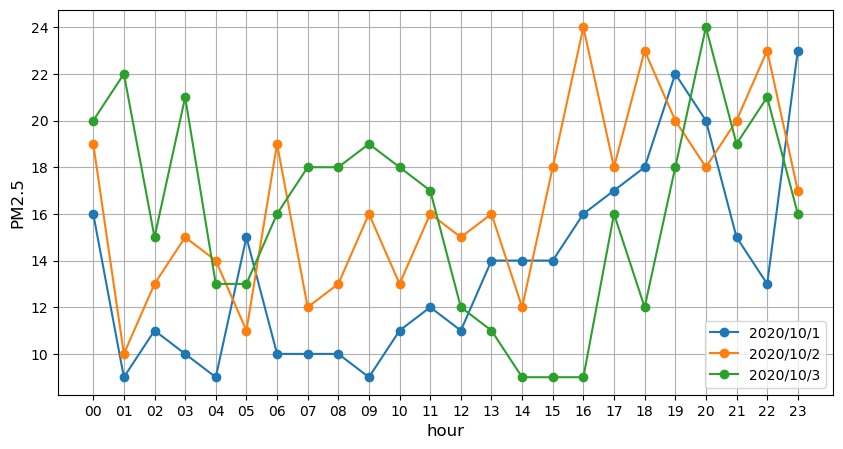

In [9]:
plt.figure(figsize=(10,5))
plt.plot(data.iloc[9, :].map(lambda x: float(x)), '-o')
plt.plot(data.iloc[9+18, :].map(lambda x: float(x)), '-o')
plt.plot(data.iloc[9+18+18, :].map(lambda x: float(x)), '-o')
plt.grid()
plt.xlabel('hour', fontsize=12)
plt.ylabel('PM2.5', fontsize=12)
plt.legend(['2020/10/1', '2020/10/2', '2020/10/3'])
plt.show()

 ### b. 缺失值以及無效值以前後一小時平均值取代 (如果前一小時仍有空值，再取更前一小時)

In [10]:
# 避免在搜尋時誤抓到AMB_TEMP，故在多下條件確定取的缺失值找到的元素去除空格長度為1

def find_target(df, i, j, targets=['#', '*', 'x', 'A']):
    x = df.iloc[i,j]
    for target in targets:
        if str(x).rfind(target)!=-1 and len(str(x).strip())==1:
            return True
        elif str(x).rfind(target)!=-1 and len(str(x).strip())!=1:
            print("Checker", x)
    return False 


def get_previous_number(df, i, j, symbol_list):
    n, m = df.shape
    if i < 0:
        return -1, -1
    
    elif j==-1:
        return get_previous_number(df, i-18, m-1, symbol_list)
    
    elif find_target(df, i, j, symbol_list):
        return get_previous_number(df, i, j-1, symbol_list)
    
    else:
        return i, j

    
def get_next_number(df, i, j, symbol_list):
    n, m = df.shape
    if i > n:
        return -1, -1
    
    elif j==len(df.columns):
        return get_next_number(df, i+18, 0, symbol_list)
    
    elif find_target(df, i, j, symbol_list):
        return get_next_number(df, i, j+1, symbol_list)
    
    else:
        return i, j


def check_value(df, i, j, Invalid_values):
    return find_target(df, i, j, Invalid_values)


def filled_avg_value(df):
    Invalid_values = ['#', '*', 'x', 'A']
    n, m = df.shape
    for i in range(n):
        for j in range(m):
            if check_value(df, i, j, Invalid_values):
                prev_index = get_previous_number(df, i, j, Invalid_values)
                next_index = get_next_number(df, i, j, Invalid_values)
                if prev_index==(-1,-1): prev_index=next_index
                elif next_index==(-1,-1): next_index=prev_index
                df.iloc[i, j] = str(float(df.iloc[prev_index]) + float(df.iloc[next_index])/2)
    
    return df


In [11]:
data = filled_avg_value(data).astype(float)
data.head()

,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
4933,23.70,23.80,23.80,23.90,23.90,23.80,24.10,24.70,26.00,27.20,...,29.90,29.60,28.70,27.50,26.40,25.70,25.50,25.30,24.90,24.50
4934,1.97,1.95,1.96,1.96,1.95,1.96,1.97,1.97,1.96,1.98,...,1.97,1.98,1.97,2.00,2.03,2.04,2.05,2.02,2.10,2.14
4935,0.23,0.22,0.21,0.20,0.20,0.22,0.24,0.29,0.27,0.33,...,0.29,0.30,0.33,0.38,0.46,0.50,0.45,0.39,0.46,0.45
4936,0.06,0.05,0.03,0.03,0.03,0.04,0.04,0.05,0.06,0.07,...,0.06,0.07,0.09,0.11,0.13,0.15,0.10,0.07,0.12,0.18
4937,1.20,0.70,0.50,0.70,0.50,0.30,0.70,0.90,1.00,1.80,...,1.30,1.00,0.90,0.80,0.50,0.90,0.90,0.30,0.70,0.90


 ### c. NR表示無降雨，以0取代

In [12]:
# df[df =='NR']=0
data = data.replace(['NR'], [0.0])

### d. 將資料切割成訓練集(10.11月)以及測試集(12月)

In [13]:
train_df = data.iloc[:1098, :].copy()
test_df = data.iloc[1098:, :].copy()

In [14]:
train_df.shape, test_df.shape

((1098, 24), (558, 24))

### e. 製作時序資料: 將資料形式轉換為行(row)代表18種屬性，欄(column)代表逐時數據資料
- (hint: 將訓練集每18行合併，轉換成維度為(18,61\*24)的DataFrame(每個屬性都有61天\*24小時共1464筆資料))

In [15]:
train_X = np.hstack([train_df.iloc[0+18*i:0+18*(i+1),:] for i in range( train_df.shape[0] // 18)])
test_X = np.hstack([test_df.iloc[0+18*i:0+18*(i+1),:] for i in range( test_df.shape[0] // 18)])

In [16]:
train_X.shape

(18, 1464)

## 2. 時間序列

### a. 預測目標
1. 將未來第一個小時當預測目標  
    取6小時為一單位切割，例如第一筆資料為第0~5小時的資料(X[0])，去預測第6小時(未來第一小時)的PM2.5值(Y[0])，下一筆資料為第1~6小時的資料(X[1])去預測第7 小時的PM2.5值(Y[1])  
    `check: 切割後X的長度應為1464-6=1458`

2. 將未來第六個小時當預測目標  
    取6小時為一單位切割，例如第一筆資料為第0~5小時的資料(X[0])，去預測第11小時(未來第六小時)的PM2.5值(Y[0])，下一筆資料為第1~6小時的資料(X[1])去預測第12 小時的PM2.5值(Y[1])  
    `hint: 切割後X的長度應為1464-11=1453`

In [17]:
def get_time_series_PM2p5(data, period=6, PM2p5=9):
    time_series_data = [data[PM2p5, i+period] for i in range(data.shape[1]-period)]   
    return np.vstack(time_series_data)

In [18]:
train_y_period6_p6 = get_time_series_PM2p5(train_X, period=6)
test_y_period6_p6 = get_time_series_PM2p5(test_X, period=6)
train_y_period6_p11 = get_time_series_PM2p5(train_X, period=11)
test_y_period6_p11 = get_time_series_PM2p5(test_X, period=11)

# period = 6
# 18*(1464-period)
# train_y_p6.shape, train_y_p11.shape, test_y_p6.shape, test_y_p11.shape
train_y_period6_p6.shape, test_y_period6_p6.shape, train_y_period6_p11.shape, test_y_period6_p11.shape

((1458, 1), (738, 1), (1453, 1), (733, 1))

### b. X請分別取
variable name : `{data type}_{X/y}_period{num}_p{predict}_{frature}`  
                eg. `train_X_period6_p11_all`

1. 只有PM2.5 (e.g. X[0]會有6個特徵，即第0~5小時的PM2.5數值)

In [19]:
def get_time_series_data(data, period=6, predict=6, PM2p5=9):
    time_series_data = [data[PM2p5, i:i+period] for i in range(data.shape[1]-period)]
    return np.vstack(time_series_data)

In [20]:
train_X_period6_p6_PM2p5 = get_time_series_data(train_X, period=6, PM2p5=9)
test_X_period6_p6_PM2p5 = get_time_series_data(test_X, period=6, PM2p5=9)
train_X_period6_p11_PM2p5 = get_time_series_data(train_X, period=11, PM2p5=9)
test_X_period6_p11_PM2p5 = get_time_series_data(test_X, period=11, PM2p5=9)
train_X_period6_p6_PM2p5.shape, test_X_period6_p6_PM2p5.shape, train_X_period6_p11_PM2p5.shape, test_X_period6_p11_PM2p5.shape

((1458, 6), (738, 6), (1453, 11), (733, 11))

2. 所有18種屬性 (e.g. X[0]會有18*6個特徵，即第0~5小時的所有18種屬性數值)

In [21]:
def get_time_series_data(data, period=6, predict=6):
    time_series_data = [data[:, i:i+period].reshape(1,-1) for i in range(data.shape[1]-period)]
    return np.vstack(time_series_data)

In [22]:
train_X_period6_p6_all = get_time_series_data(train_X, period=6)
test_X_period6_p6_all = get_time_series_data(test_X, period=6)
train_X_period6_p11_all = get_time_series_data(train_X, period=11)
test_X_period6_p11_all = get_time_series_data(test_X, period=11)
train_X_period6_p6_all.shape, test_X_period6_p6_all.shape, train_X_period6_p11_all.shape, test_X_period6_p11_all.shape

((1458, 108), (738, 108), (1453, 198), (733, 198))

*依序順序如下:*  
- 用六小時，預測第6小時(下一小時)，僅用PM2.5欄位
- 用六小時，預測第11小時(往後算第6小時)，僅用PM2.5欄位
- 用六小時，預測第6小時(下一小時)，用18種欄位
- 用六小時，預測第11小時(往後算第6小時)，用18種欄位

In [23]:
data_list = [
    (train_X_period6_p6_PM2p5 , train_y_period6_p6 , test_X_period6_p6_PM2p5 , test_y_period6_p6 ),
    (train_X_period6_p11_PM2p5, train_y_period6_p11, test_X_period6_p11_PM2p5, test_y_period6_p11),
    (train_X_period6_p6_all   , train_y_period6_p6 , test_X_period6_p6_all   , test_y_period6_p6 ),
    (train_X_period6_p11_all  , train_y_period6_p11, test_X_period6_p11_all  , test_y_period6_p11),    
    ]

### c. 使用兩種模型 Linear Regression 和 XGBoost 建模

- 1. Linear Regression
- 2. XGBoost

In [24]:
class Model:
    def __init__(self, data_list, model):
        self.data_list = data_list
        self.model=model
        self.train_mae_list = []
        self.test_mae_list = []
        self.call()

    def call(self):
        for data in self.data_list:
            train_X, train_y, test_X, test_y = data
            self.model.fit(train_X, train_y)
            pred_train_y = self.model.predict(train_X)
            pred_test_y = self.model.predict(test_X)
            self.train_mae_list.append(self.cal_mae_score(train_y, pred_train_y))
            self.test_mae_list.append(self.cal_mae_score(test_y, pred_test_y))
        return None
    
    def cal_mae_score(self, y, pred_y):

        return round(metrics.mean_absolute_error(y, pred_y),4)

    def get_train_mae_score(self):

        return self.train_mae_list
    
    def get_test_mae_score(self):
    
        return self.test_mae_list


In [25]:
model_set = {'xgb': xgb.XGBRegressor(objective='reg:squarederror', verbosity=2),
             'lr':LinearRegression()}
model_key = 'xgb'
lr_model = Model(data_list, model_set['lr'])
xgb_model = Model(data_list, model_set['xgb'])

[00:19:56] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[00:19:56] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[00:19:56] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[00:19:56] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[00:19:56] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1

In [26]:
print(''.center(60,'='))
print("Training")
print(f"Linear Regression MAE: {lr_model.get_train_mae_score()}")
print(f"XGBoost           MAE: {xgb_model.get_train_mae_score()}")
print(''.center(60,'='))
print("Testing")
print(f"Linear Regression MAE: {lr_model.get_test_mae_score()}")
print(f"XGBoost           MAE: {xgb_model.get_test_mae_score()}")
print(''.center(60,'='))


Training
Linear Regression MAE: [2.6343, 2.6285, 2.38, 2.3149]
XGBoost           MAE: [0.565, 0.2891, 0.0728, 0.0535]
Testing
Linear Regression MAE: [2.5895, 2.6028, 2.6965, 2.9366]
XGBoost           MAE: [2.9475, 3.0984, 2.8753, 2.9549]


#### 參考資料 : https://codingnote.cc/zh-tw/p/103468/